In [1]:
import os

In [2]:
import sys
sys.path.append('../')
from src import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
model = Load_model(resnet_val=50, device = device)

save_folder_addr = '../res50/'
model_file_name = 'Eurosat100'
model.load_state_dict(torch.load(save_folder_addr + model_file_name))

Model Loaded


<All keys matched successfully>

In [5]:
data_folder = 'C:/dev/EuroSAT/'
root = os.path.join(data_folder, '2750/')

In [6]:
if __name__ == '__main__':
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    random.seed(0)
    
    print("pytorch version", torch.__version__)
    
    criteria = torch.nn.CrossEntropyLoss()
    resnet_model = Load_model(resnet_val=50, device = device)
    train_loader, val_loader = make_dataloaders(root, batch_size_val=128)
    
    resnet_model=resnet_model.to(device)

pytorch version 2.1.2
Model Loaded


In [7]:
import hashlib

val_data_string = str(val_loader.dataset)
current_hash = hashlib.sha256(val_data_string.encode()).hexdigest()

with open(save_folder_addr + 'val_data_hash.txt', 'r') as file:
    original_hash = file.readline()


In [8]:
if current_hash == original_hash:
    print('Validaiton set is the same')
else:
    Exception('Validation Set is different')    

Validaiton set is the same


In [9]:
from sklearn.metrics import confusion_matrix

model.eval()

all_labels = []
all_predictions = []

for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
print(cm)


[[2242    8   74    8    0    2   46    0    5    7]
 [   1 2025   74    0    0    0    0    0    1  286]
 [  25    8 2282    0    0    1   75    0    0    0]
 [   5    0   73 1882    2    0   25    0    2    0]
 [   0    0  110   18 1864    0    6    0    0    0]
 [ 173  251  502   11    0  575   61    0    6   13]
 [  64    0  548    5    2    0 1372    0    0    0]
 [   0    0  831    7  155    0   12 1384    0    0]
 [  47   17  145   63    2    0   11    0 1697    9]
 [  11   19   27    0    0    1    0    0    1 2325]]


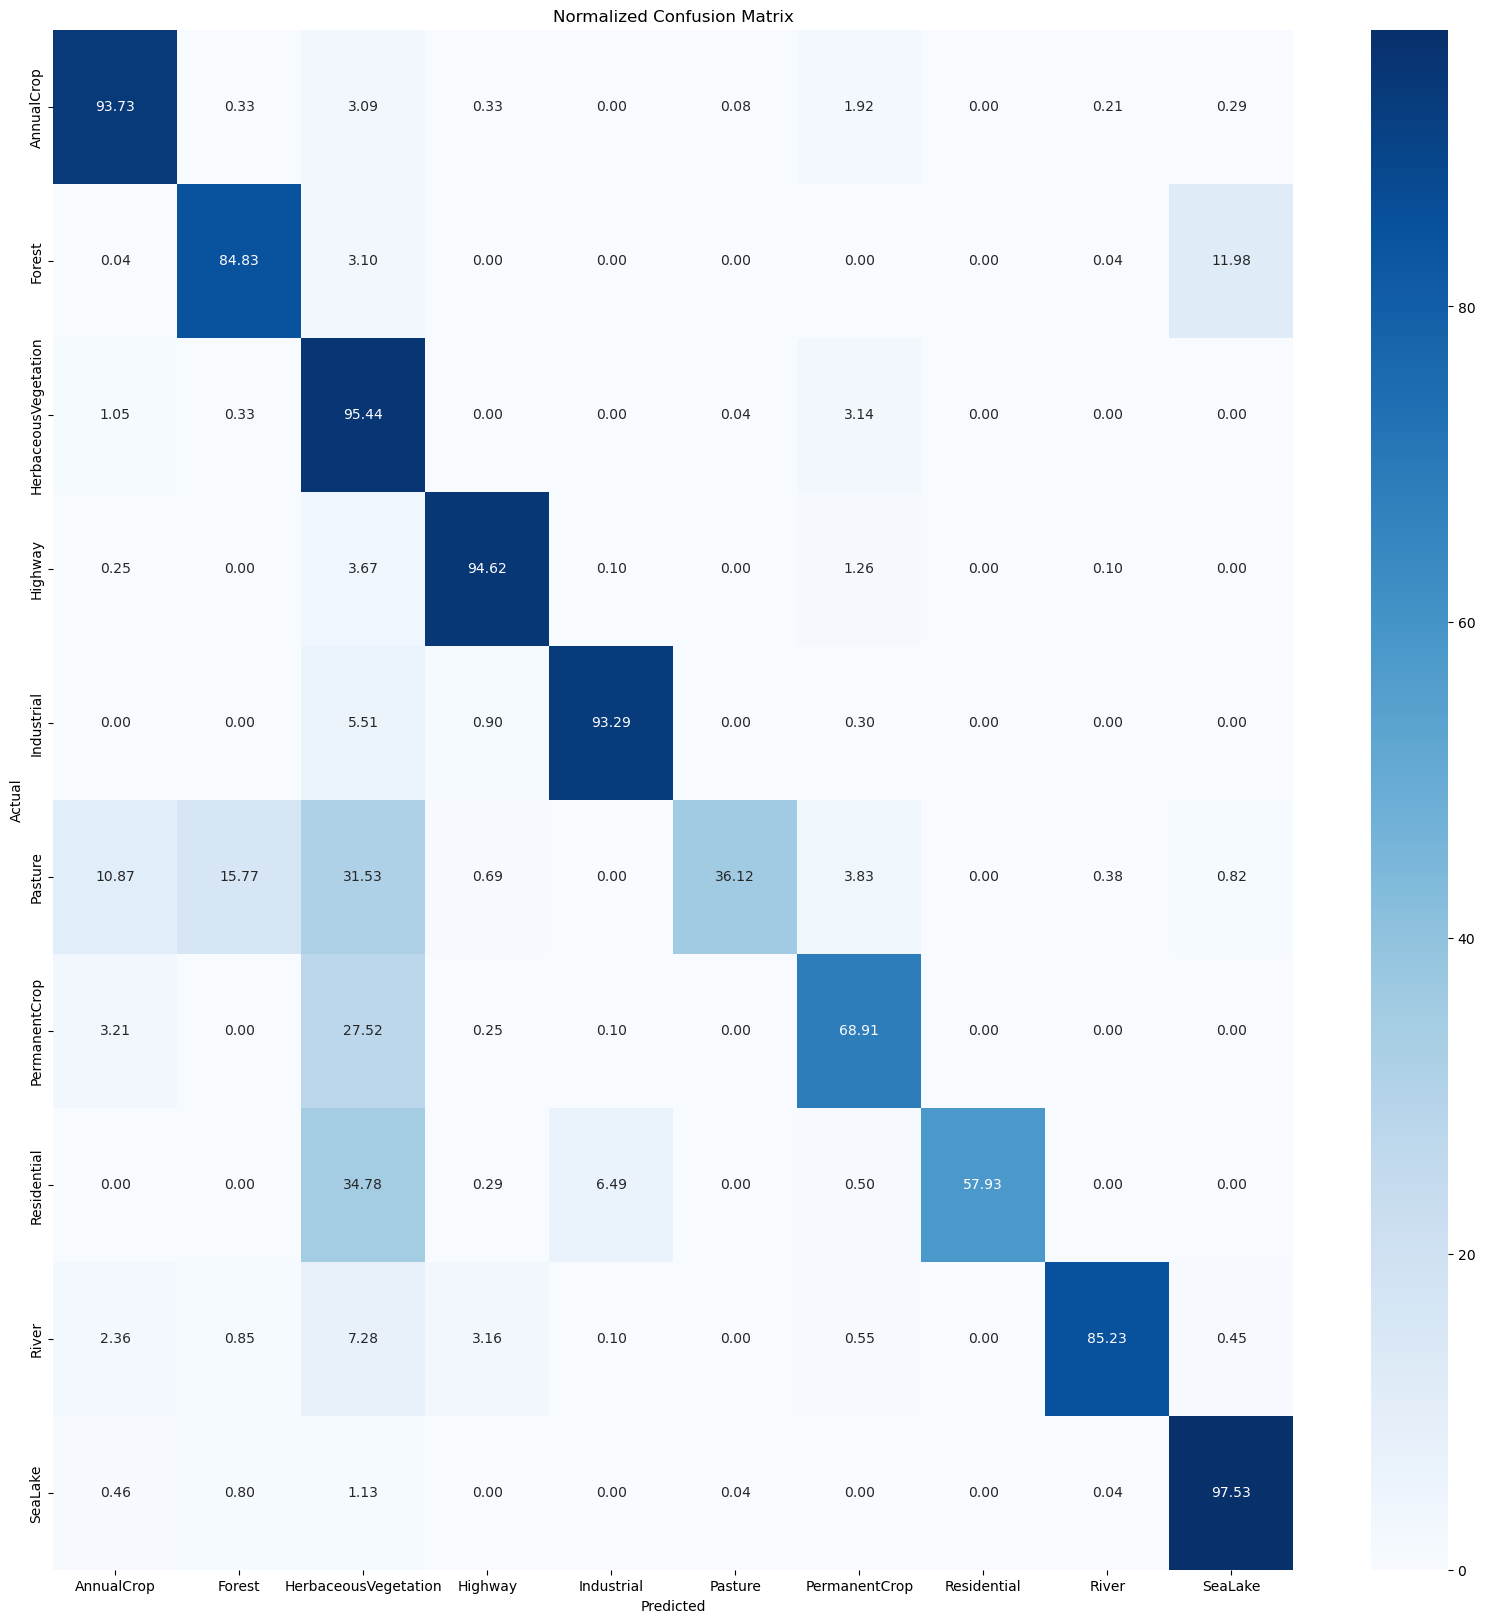

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_labels = [name for name in os.listdir(root) if os.path.isdir(os.path.join(root, name))]

cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_norm = cm / cm_sum.astype(float) * 100

plt.figure(figsize=(20, 20))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()